In [1]:
import pandas as pd
import numpy as np
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ravdess = "/content/drive/MyDrive/AudioFiles"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_11', 'Actor_10', 'Actor_12', 'Actor_14', 'Actor_15', 'Actor_17', 'Actor_19', 'Actor_18', 'Actor_16', 'Actor_13', 'Actor_20', 'Actor_21', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_03', 'Actor_04', 'Actor_24', 'Actor_22', 'Actor_23', 'Actor_05', 'Actor_02', 'Actor_09', 'Actor_08']


In [4]:
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(ravdess, dir, file))

In [6]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

In [7]:
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/AudioFiles/Actor_11/03-...
1,calm,/content/drive/MyDrive/AudioFiles/Actor_11/03-...
2,neutral,/content/drive/MyDrive/AudioFiles/Actor_11/03-...
3,neutral,/content/drive/MyDrive/AudioFiles/Actor_11/03-...
4,calm,/content/drive/MyDrive/AudioFiles/Actor_11/03-...


In [8]:
print(Ravdess_df.Emotions.value_counts())

Emotions
calm        192
surprise    192
fear        192
angry       192
disgust     192
sad         192
happy       192
neutral      96
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

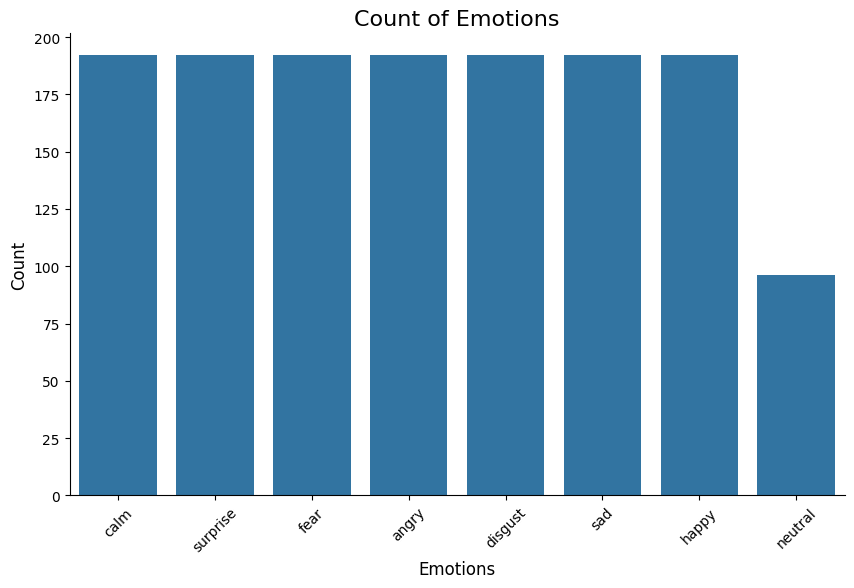

In [10]:
emotion_counts = Ravdess_df['Emotions'].value_counts()
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)

In [11]:
data_array, sample_rate = librosa.load(Ravdess_df['Path'].iloc[0])
sample_rate

22050

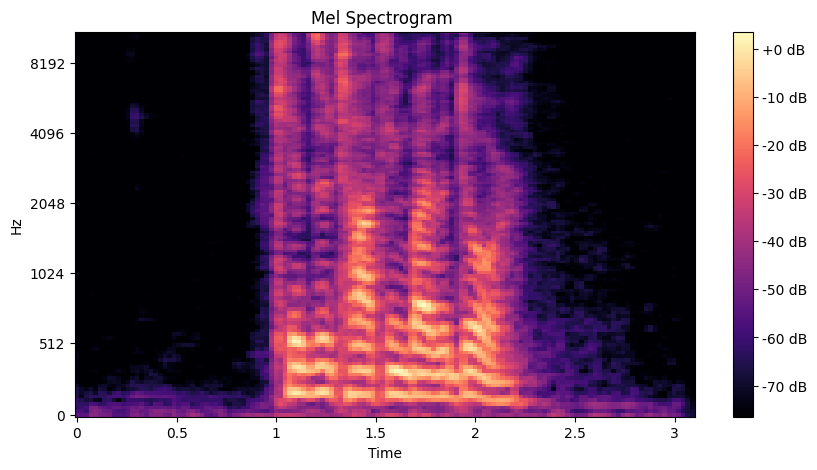

In [12]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128,fmax=5000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sample_rate, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

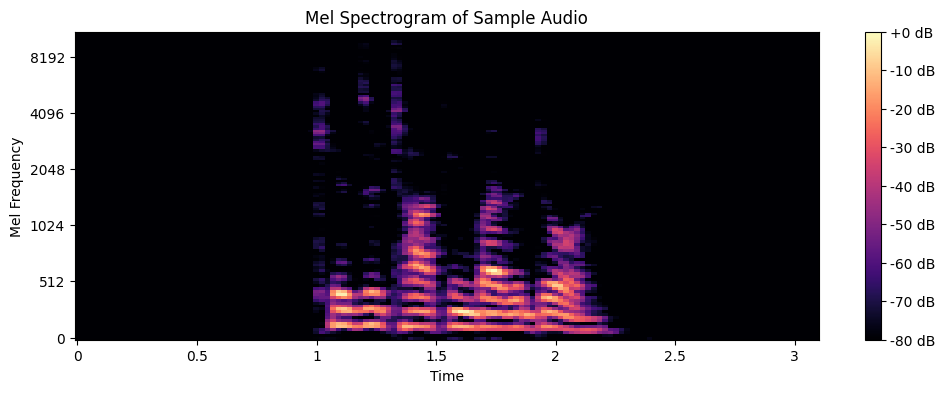

In [13]:
S = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Sample Audio')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.show()

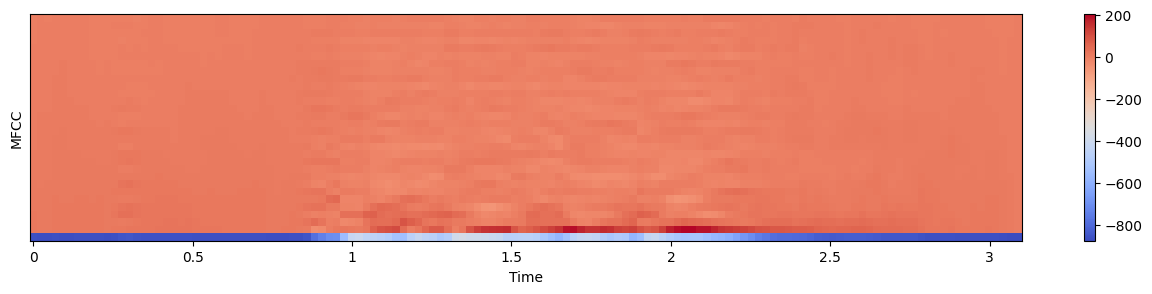

In [14]:
mfcc = librosa.feature.mfcc(y=data_array, sr=sample_rate, n_mfcc=30)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(data_array,rate=sample_rate)

In [15]:
def noise(data):
    noise_amp = 0.045*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

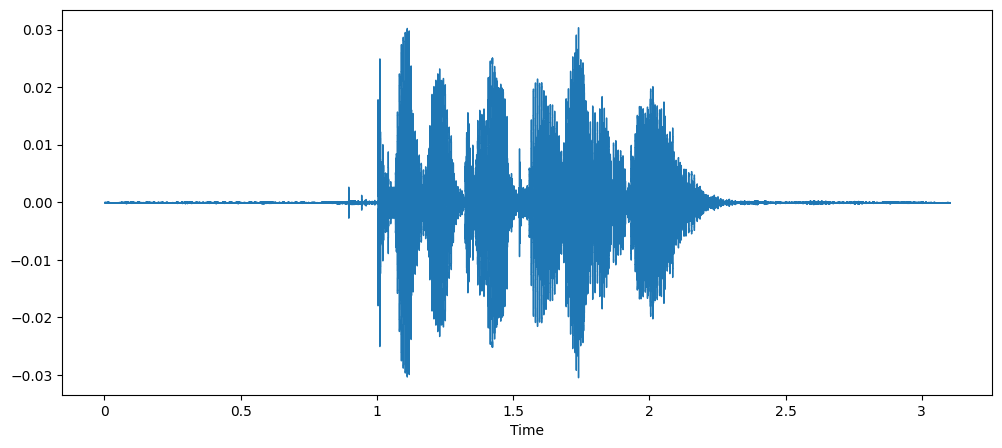

In [16]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data_array, sr=sample_rate)
ipd.Audio(data_array,rate=sample_rate)

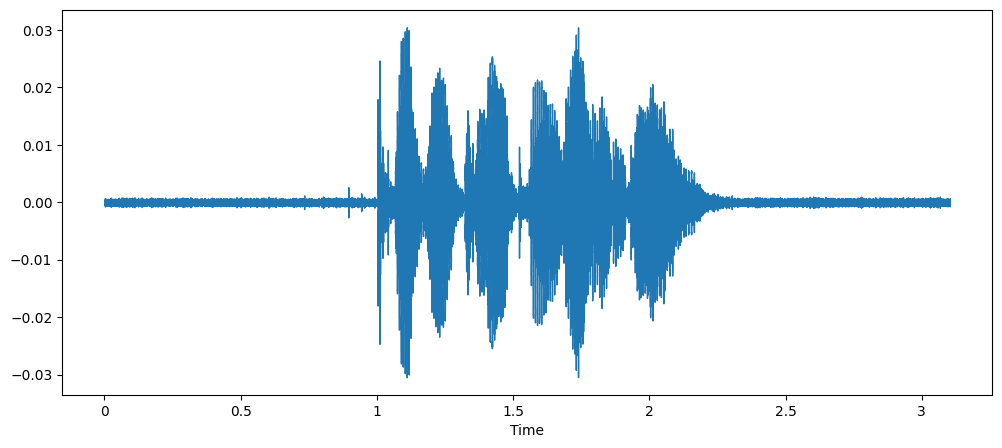

In [17]:
x = noise(data_array)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

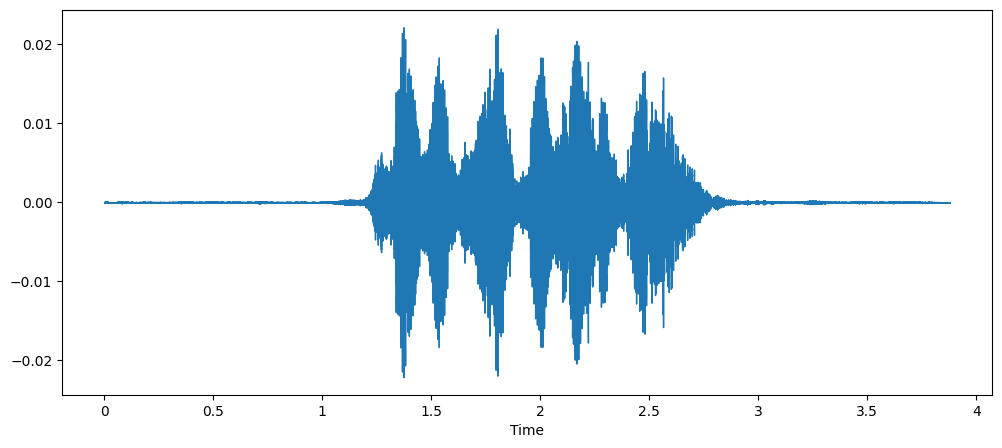

In [18]:
x = stretch(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

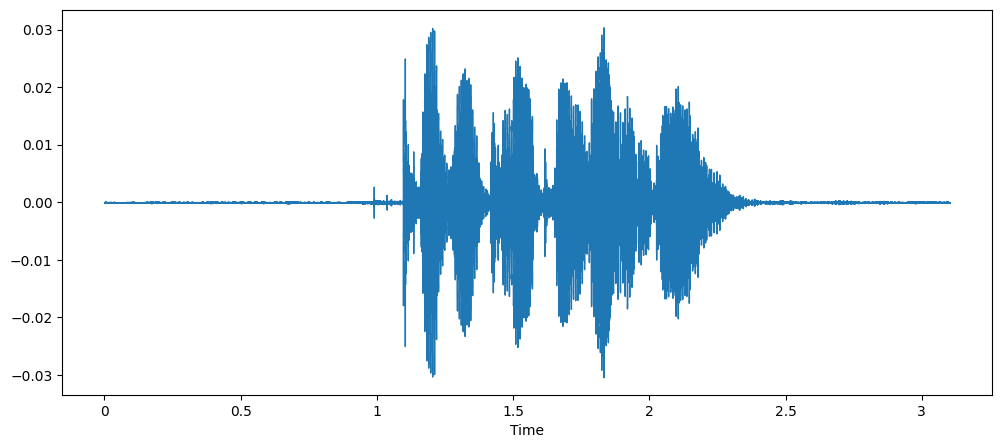

In [19]:
x = shift(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

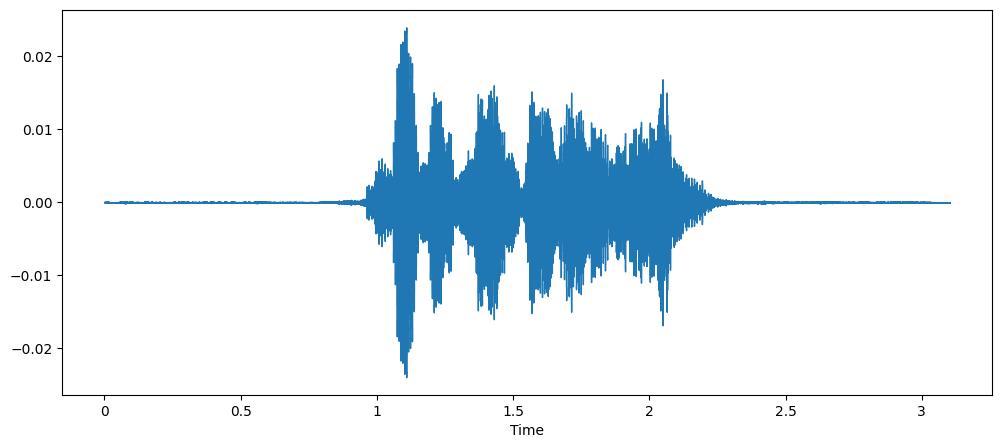

In [20]:
x = pitch(data=data_array,sampling_rate=sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

In [21]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
#mfcc
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path = path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [22]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [23]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()

def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = Ravdess_df.Path
emotions = Ravdess_df.Emotions


results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Time:  323.01002471699996


In [24]:
len(X), len(Y), Ravdess_df.Path.shape

(5760, 5760, (1440,))

In [25]:
emotions = pd.DataFrame(X)
emotions['Emotions'] = Y
emotions.to_csv('emotion.csv', index=False)
emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.160156,0.278809,0.392578,0.486328,0.384277,0.413574,0.428223,0.389648,0.348633,0.200684,...,2.115801,2.080435,2.042422,2.001880,1.958914,1.913651,1.866193,1.816691,1.765270,neutral
1,0.208496,0.322266,0.444336,0.487305,0.464355,0.477539,0.472168,0.457031,0.450684,0.377441,...,8.107335,4.769731,-0.760520,-3.051281,4.167670,-0.948487,-1.647141,-0.143072,0.257121,neutral
2,0.049805,0.071289,0.083008,0.086914,0.062988,0.081543,0.121582,0.108398,0.093262,0.053223,...,2.208761,2.120330,2.026781,1.928688,1.826659,1.721308,1.613303,1.503262,1.391848,neutral
3,0.247070,0.364258,0.485352,0.484375,0.488281,0.497070,0.496582,0.509277,0.497070,0.487305,...,-2.643660,7.349194,1.130188,2.733610,1.990091,3.534531,-0.802138,0.230926,2.257037,neutral
4,0.220703,0.316406,0.319336,0.222168,0.174316,0.128418,0.222168,0.226074,0.274414,0.416504,...,10.280500,3.889901,3.798279,6.211890,2.534471,2.870324,4.707954,0.895819,-0.461588,calm


In [26]:
Emotions = pd.read_csv('emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.160156,0.278809,0.392578,0.486328,0.384277,0.413574,0.428223,0.389648,0.348633,0.200684,...,2.115801,2.080435,2.042422,2.001880,1.958914,1.913651,1.866193,1.816691,1.765270,neutral
1,0.208496,0.322266,0.444336,0.487305,0.464355,0.477539,0.472168,0.457031,0.450684,0.377441,...,8.107335,4.769731,-0.760520,-3.051281,4.167670,-0.948487,-1.647141,-0.143072,0.257121,neutral
2,0.049805,0.071289,0.083008,0.086914,0.062988,0.081543,0.121582,0.108398,0.093262,0.053223,...,2.208761,2.120330,2.026781,1.928688,1.826659,1.721308,1.613303,1.503262,1.391848,neutral
3,0.247070,0.364258,0.485352,0.484375,0.488281,0.497070,0.496582,0.509277,0.497070,0.487305,...,-2.643660,7.349194,1.130188,2.733610,1.990091,3.534531,-0.802138,0.230926,2.257037,neutral
4,0.220703,0.316406,0.319336,0.222168,0.174316,0.128418,0.222168,0.226074,0.274414,0.416504,...,10.280500,3.889901,3.798279,6.211890,2.534471,2.870324,4.707954,0.895819,-0.461588,calm


In [27]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [28]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [29]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [32]:
sequence_data = Emotions['2375'].values
target_data = Emotions['Emotions'].values

In [33]:
encoder = OneHotEncoder(sparse=False)
target_data = encoder.fit_transform(target_data.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
X_train, X_test, y_train, y_test = train_test_split(sequence_data, target_data, test_size=0.2, random_state=42)

In [35]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

In [36]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(1))

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
144/144 [==============================] - 4s 15ms/step - loss: 0.1104 - val_loss: 0.1094
Epoch 2/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 3/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 4/100
144/144 [==============================] - 1s 5ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 5/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 6/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 7/100
144/144 [==============================] - 1s 5ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 8/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 9/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 10/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1094 - val_l

In [40]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

36/36 [==============================] - 0s 3ms/step - loss: 0.1094
Test loss: 0.1093750149011612
36/36 [==============================] - 0s 3ms/step - loss: 0.1094
Test accuracy: 0.1093750149011612


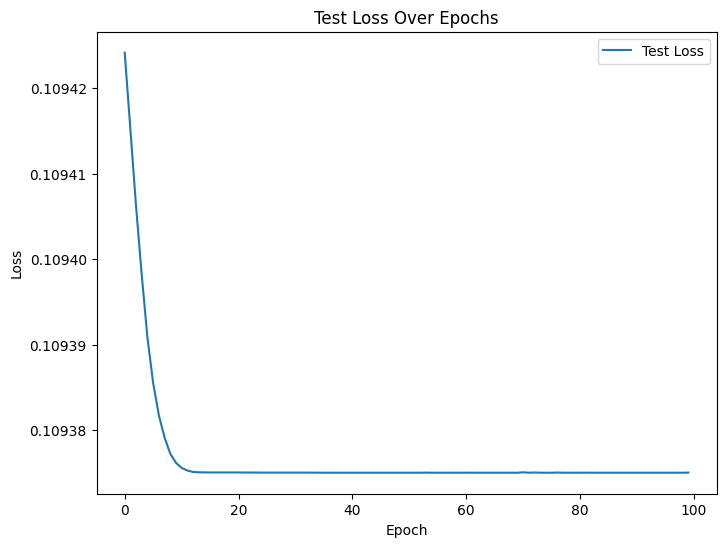

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Test Loss Over Epochs')
plt.show()

In [42]:
new_data = np.array([0.5])
scaled_data = scaler.transform(new_data.reshape(-1, 1))
prediction = model.predict(scaled_data)
print(f'Predicted probabilities: {prediction}')

1/1 [==============================] - 0s 357ms/step
Predicted probabilities: [[0.12520152]]


Training for 50 epochs...
Test loss for 50 epochs: 0.109375


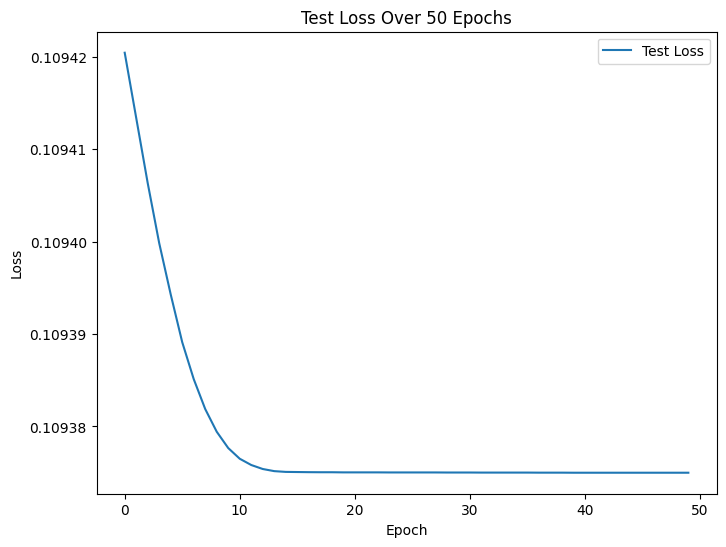

Training for 100 epochs...
Test loss for 100 epochs: 0.109375


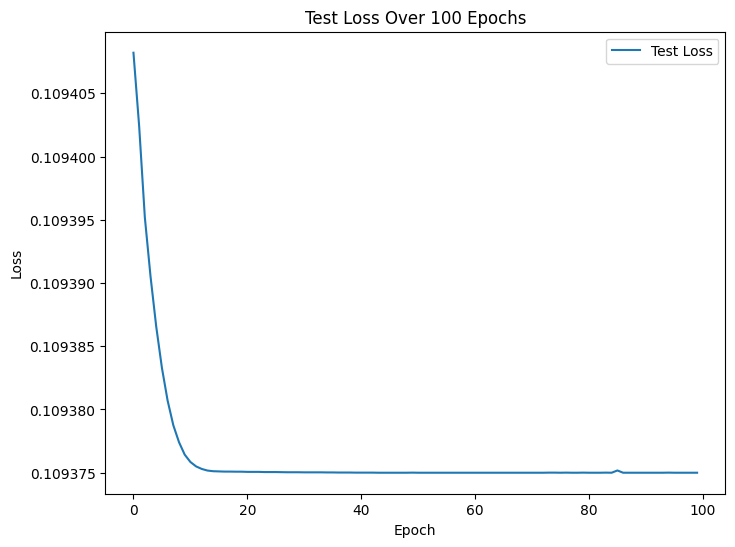

Training for 150 epochs...
Test loss for 150 epochs: 0.10937505960464478


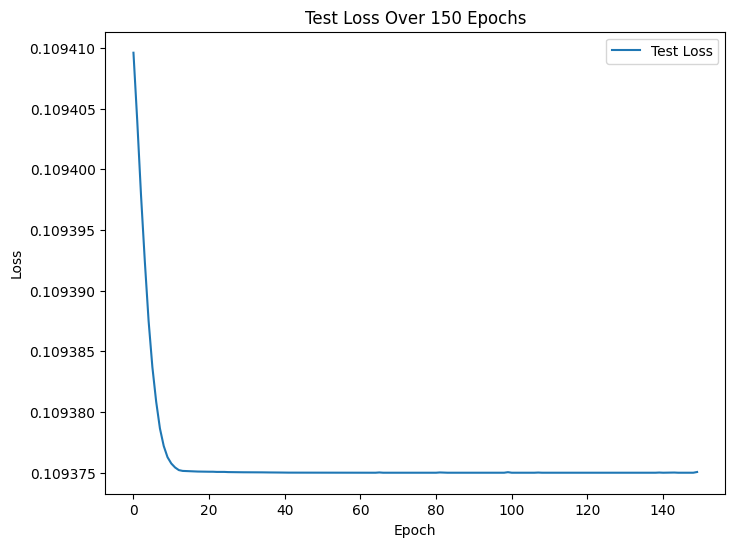

Training for 200 epochs...
Test loss for 200 epochs: 0.109375


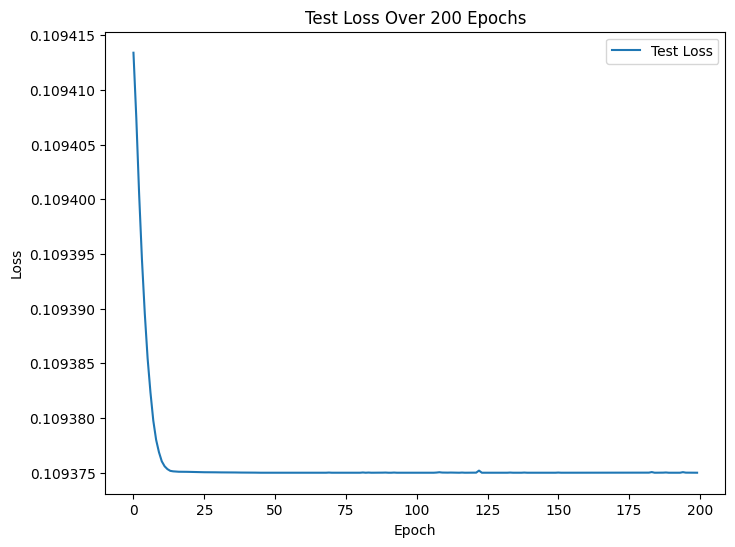

In [43]:
# Function to train the model and visualize results
def train_and_visualize(X_train, y_train, X_test, y_test, epochs):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    print(f"Training for {epochs} epochs...")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss for {epochs} epochs: {test_loss}')

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Test Loss Over {epochs} Epochs')
    plt.show()

# Different epochs to try
epoch_list = [50, 100, 150, 200]

# Train and visualize for each epoch count
for epochs in epoch_list:
    train_and_visualize(X_train, y_train, X_test, y_test, epochs)


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import warnings

warnings.filterwarnings('ignore')

In [ ]:
ravdess = "/content/drive/MyDrive/AudioFiles"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_09', 'Actor_08', 'Actor_05', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_01', 'Actor_24', 'Actor_23', 'Actor_22', 'Actor_07', 'Actor_06', 'Actor_21', 'Actor_20', 'Actor_19', 'Actor_18', 'Actor_17', 'Actor_16', 'Actor_15', 'Actor_14', 'Actor_13', 'Actor_12', 'Actor_11', 'Actor_10']


In [ ]:
emotions = []
paths = []

# Process each actor directory
for actor in ravdess_directory_list:
    actor_path = os.path.join(ravdess, actor)
    actor_files = os.listdir(actor_path)

    # Process each audio file in the actor's directory
    for audio_file in actor_files:
        # Extract the emotion from the filename
        file_parts = audio_file.split('.')[0].split('-')
        emotion_code = int(file_parts[2])

        # Append the emotion and file path to the respective lists
        emotions.append(emotion_code)
        paths.append(os.path.join(actor_path, audio_file))

# Create a DataFrame from the lists
data = pd.DataFrame({
    'Emotion': emotions,
    'File_Path': paths
})

# Define a mapping from emotion codes to labels
emotion_labels = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}

# Replace emotion codes with labels in the DataFrame
data['Emotion'] = data['Emotion'].map(emotion_labels)

# Display the first few and last few rows of the DataFrame together
head_and_tail = pd.concat([data.head(), data.tail()])
print("First and last few rows of the DataFrame:")
print(head_and_tail)

# Display a summary of the DataFrame
print("\nSummary of the DataFrame:")
print(data.describe(include='all'))

# Display the count of each emotion
emotion_counts = data['Emotion'].value_counts()
print("\nCount of each emotion:")
print(emotion_counts)

First and last few rows of the DataFrame:
      Emotion                                          File_Path
0     neutral  /content/drive/MyDrive/AudioFiles/Actor_09/03-...
1     disgust  /content/drive/MyDrive/AudioFiles/Actor_09/03-...
2     disgust  /content/drive/MyDrive/AudioFiles/Actor_09/03-...
3        fear  /content/drive/MyDrive/AudioFiles/Actor_09/03-...
4        fear  /content/drive/MyDrive/AudioFiles/Actor_09/03-...
1435     calm  /content/drive/MyDrive/AudioFiles/Actor_10/03-...
1436  neutral  /content/drive/MyDrive/AudioFiles/Actor_10/03-...
1437  neutral  /content/drive/MyDrive/AudioFiles/Actor_10/03-...
1438     calm  /content/drive/MyDrive/AudioFiles/Actor_10/03-...
1439  neutral  /content/drive/MyDrive/AudioFiles/Actor_10/03-...

Summary of the DataFrame:
        Emotion                                          File_Path
count      1440                                               1440
unique        8                                               1440
top     disgust

In [ ]:
class FeatureExtractor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length

    def zcr(self, data):
        return librosa.feature.zero_crossing_rate(data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def rmse(self, data):
        return librosa.feature.rms(y=data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def mfcc(self, data, sr, n_mfcc=13, flatten=True):
        mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc, hop_length=self.hop_length)
        return mfcc_features.T.flatten() if flatten else mfcc_features.T

    def chroma(self, data, sr):
        chroma_features = librosa.feature.chroma_stft(y=data, sr=sr, hop_length=self.hop_length)
        return chroma_features.T.flatten()

    def spectral_contrast(self, data, sr):
        contrast_features = librosa.feature.spectral_contrast(y=data, sr=sr, hop_length=self.hop_length)
        return contrast_features.T.flatten()

    def mel_spectrogram(self, data, sr):
        mel_features = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=self.hop_length)
        return librosa.power_to_db(mel_features).flatten()

    def extract_features(self, data, sr):
        zcr_features = self.zcr(data)
        rmse_features = self.rmse(data)
        mfcc_features = self.mfcc(data, sr)
        chroma_features = self.chroma(data, sr)
        spectral_contrast_features = self.spectral_contrast(data, sr)
        mel_spectrogram_features = self.mel_spectrogram(data, sr)
        return np.concatenate([zcr_features,
                                rmse_features,
                                mfcc_features,
                                chroma_features,
                                spectral_contrast_features,
                                mel_spectrogram_features])

In [ ]:
class DataAugmentation:
    @staticmethod
    def noise(data, noise_factor=0.005):
        noise_amp = noise_factor * np.random.uniform() * np.amax(data)
        return data + noise_amp * np.random.normal(size=data.shape[0])

    @staticmethod
    def pitch(data, sr, n_steps=4):
        return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

In [ ]:
from joblib import Parallel, delayed

class AudioProcessor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.feature_extractor = FeatureExtractor(frame_length, hop_length)
        self.augmenter = DataAugmentation()

    def get_features(self, path, duration=2.5, offset=0.6):
        data, sr = librosa.load(path, duration=duration, offset=offset)
        features = [self.feature_extractor.extract_features(data, sr)]

        noised_audio = self.augmenter.noise(data)
        features.append(self.feature_extractor.extract_features(noised_audio, sr))

        pitched_audio = self.augmenter.pitch(data, sr)
        features.append(self.feature_extractor.extract_features(pitched_audio, sr))

        pitched_noised_audio = self.augmenter.noise(pitched_audio)
        features.append(self.feature_extractor.extract_features(pitched_noised_audio, sr))

        return np.array(features)

    def process_feature(self, path, emotion):
        features = self.get_features(path)
        X = features.tolist()
        Y = [emotion] * len(features)
        return X, Y

    def process_dataset(self, df, n_jobs=-1):
        paths = df['File_Path'].values
        emotions = df['Emotion'].values

        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = [], []
        for result in results:
            X.extend(result[0])
            Y.extend(result[1])

        # Pad or truncate sequences to the same length
        max_len = max(len(x) for x in X)
        X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len] for x in X])

        return X, np.array(Y)

# Example usage
processor = AudioProcessor()

X, Y = processor.process_dataset(data)
print(X.shape, Y.shape)

(5760, 17496) (5760,)


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

def prepare_data_for_cnn(X, Y):
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler.pkl')

    # Encode the labels
    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)
    joblib.dump(encoder, 'label_encoder.pkl')

    num_classes = len(np.unique(Y))
    Y = to_categorical(Y, num_classes=num_classes)

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Reshape the data for CNN (adding an extra dimension for channels)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

    return X_train, X_test, Y_train, Y_test, num_classes

# Example usage
X_train, X_test, Y_train, Y_test, num_classes = prepare_data_for_cnn(X, Y)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4608, 17496, 1, 1) (4608, 8) (1152, 17496, 1, 1) (1152, 8)


In [ ]:
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D((2, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage
cnn_model = build_cnn_model(X_train.shape[1:], num_classes)

# Train the model
history = cnn_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
144/144 [==============================] - 145s 990ms/step - loss: 1.8169 - accuracy: 0.3613 - val_loss: 1.3287 - val_accuracy: 0.4991
Epoch 2/10
144/144 [==============================] - 149s 1s/step - loss: 0.9911 - accuracy: 0.6489 - val_loss: 0.8296 - val_accuracy: 0.7205
Epoch 3/10
144/144 [==============================] - 147s 1s/step - loss: 0.4138 - accuracy: 0.8717 - val_loss: 0.5205 - val_accuracy: 0.8429
Epoch 4/10
144/144 [==============================] - 149s 1s/step - loss: 0.1287 - accuracy: 0.9735 - val_loss: 0.3297 - val_accuracy: 0.9036
Epoch 5/10
144/144 [==============================] - 151s 1s/step - loss: 0.0434 - accuracy: 0.9907 - val_loss: 0.2956 - val_accuracy: 0.9288
Epoch 6/10
144/144 [==============================] - 140s 972ms/step - loss: 0.0271 - accuracy: 0.9963 - val_loss: 0.2908 - val_accuracy: 0.9245
Epoch 7/10
144/144 [==============================] - 151s 1s/step - loss: 0.0174 - accuracy: 0.9980 - val_loss: 0.2075 - val_accuracy: 

In [ ]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17496, 1, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8748, 1, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8748, 1, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4374, 1, 32)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 139968)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

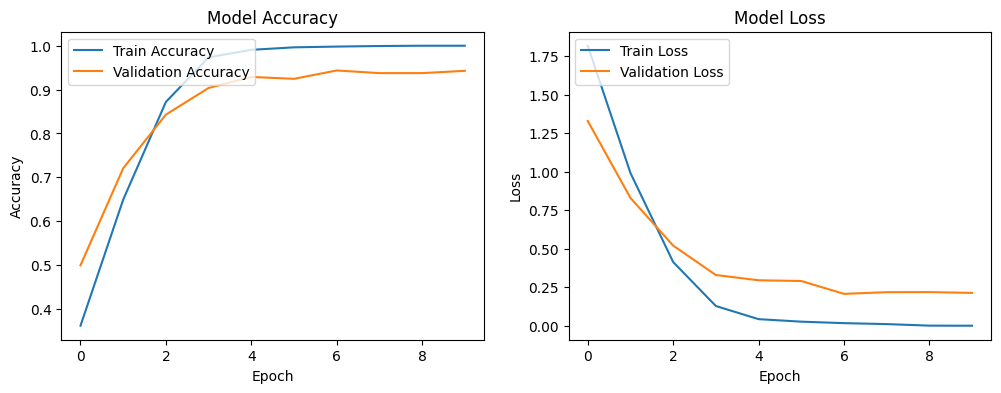

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

36/36 [==============================] - 22s 602ms/step


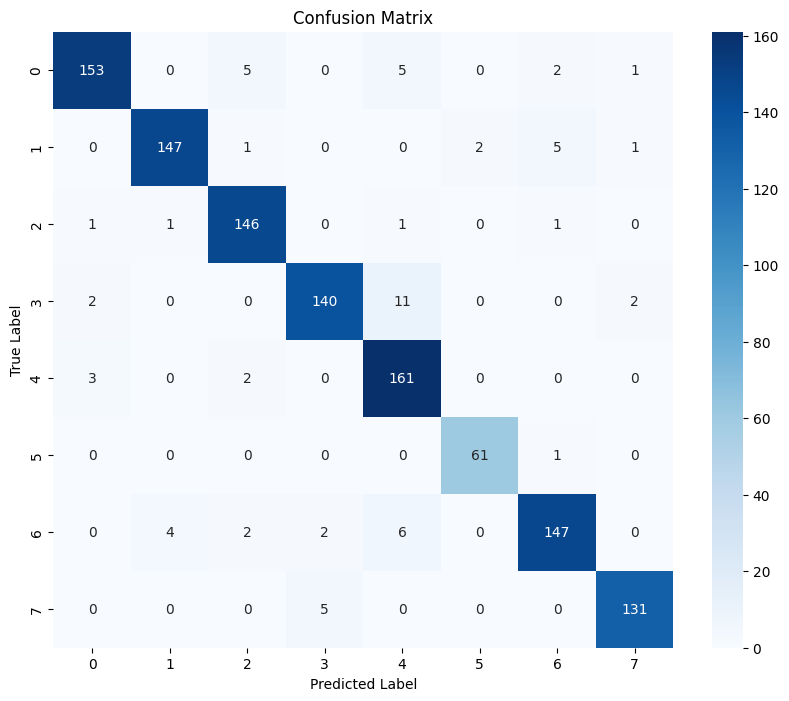

In [ ]:
Y_pred = cnn_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
cnn_model.save("cnn_model_2.1_.h5")